In [1]:
from tempfile import mkdtemp
from shutil import rmtree

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

In [2]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

train.head()

,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
ID,,,,,,,,,,,,,,,,,,
ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21454 entries, ID_AAIethGy to ID_zzqQlHgY
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country                                  21454 non-null  object 
 1   year                                     21454 non-null  int64  
 2   urban_or_rural                           21454 non-null  object 
 3   ghsl_water_surface                       21454 non-null  float64
 4   ghsl_built_pre_1975                      21454 non-null  float64
 5   ghsl_built_1975_to_1990                  21454 non-null  float64
 6   ghsl_built_1990_to_2000                  21454 non-null  float64
 7   ghsl_built_2000_to_2014                  21454 non-null  float64
 8   ghsl_not_built_up                        21454 non-null  float64
 9   ghsl_pop_density                         21454 non-null  float64
 10  landcover_crops_fraction           

# 1. Basic EDA

In [4]:
# Get countries present in both train & test
set(train["country"].unique()) & set(test["country"].unique())

set()

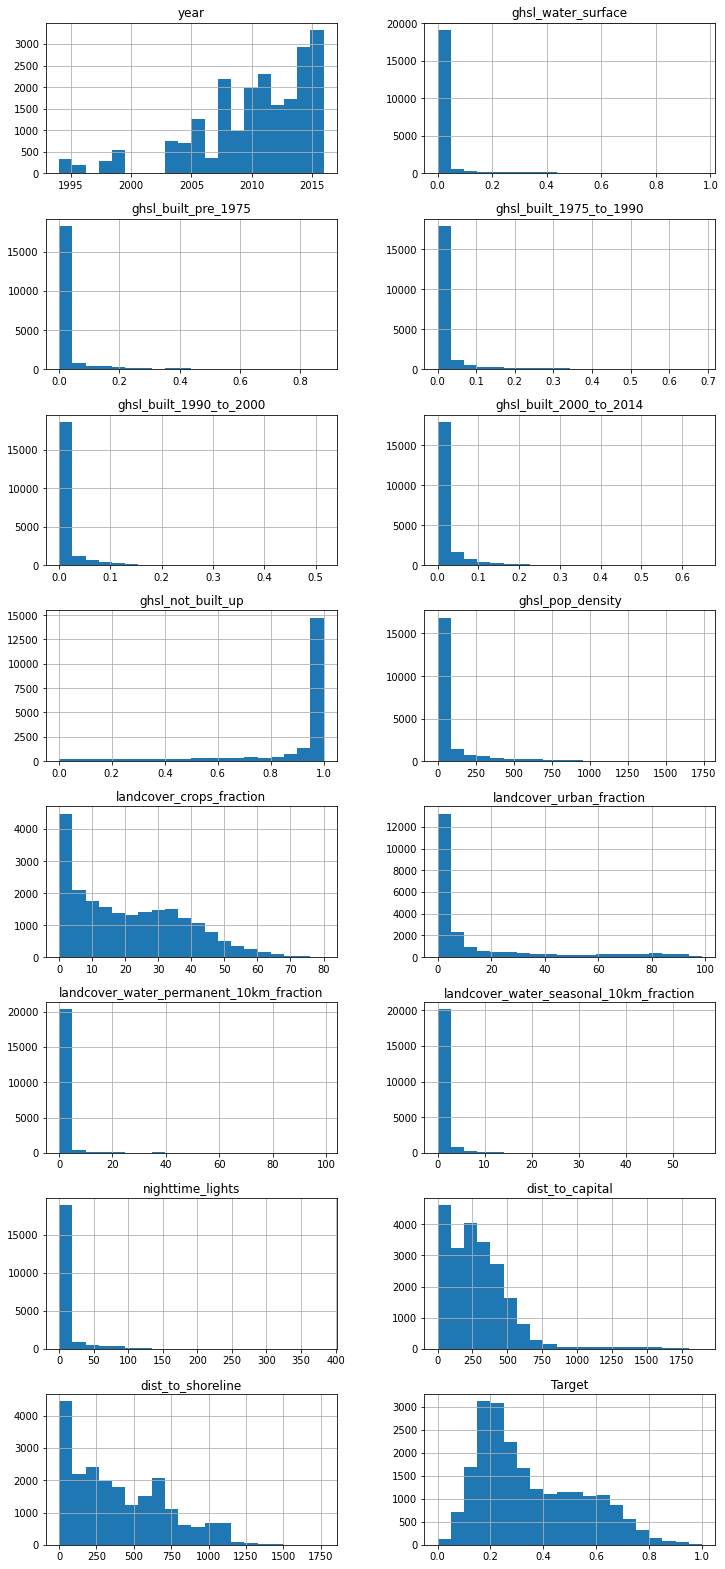

In [5]:
_ = train.hist(figsize=(12, 28), layout=(8, 2), bins=20)

<AxesSubplot:>

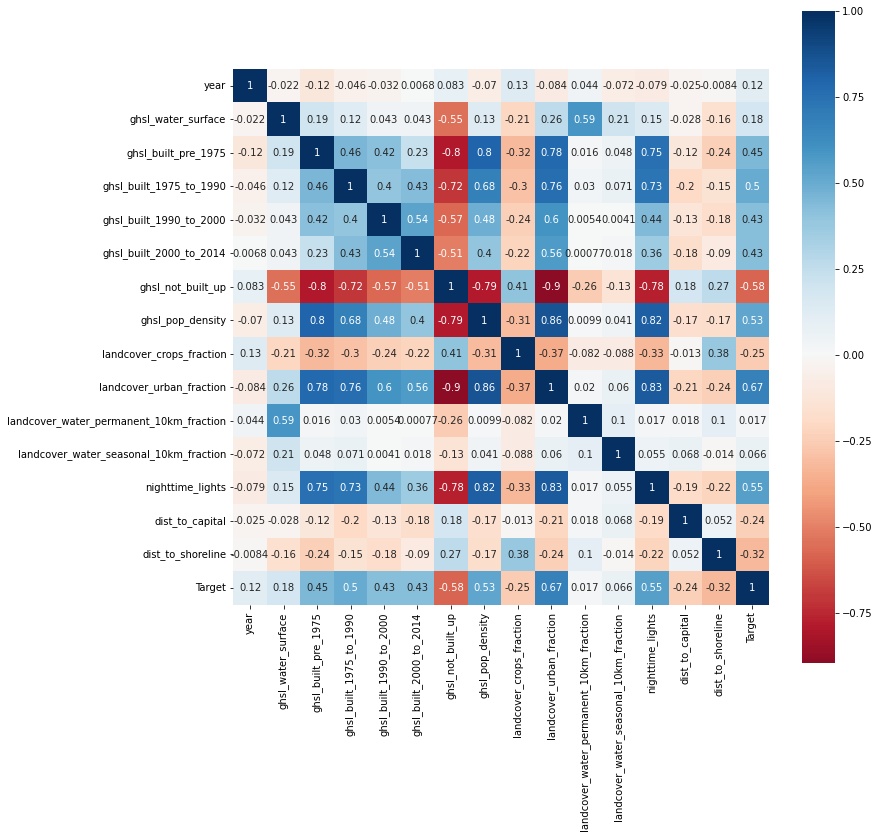

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(train.corr(), annot=True, center=0, cmap="RdBu", square=True, ax=ax)

# 2. Modelling

In [7]:
X, y = train.iloc[:, :-1], train["Target"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=4)

preprocessing = ColumnTransformer([
    ("categorical", OneHotEncoder(handle_unknown="ignore"), [2]),
    (
        "numeric",
        QuantileTransformer(output_distribution="normal", random_state=2),
        make_column_selector(dtype_include="number")
    )
])

cache_dir = mkdtemp()
model_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("estimator", ExtraTreesRegressor(random_state=8, n_jobs=4))
    ],
    memory=cache_dir,
)

In [8]:
param_grid = {
    "estimator__n_estimators": [200, 500],
    "estimator__max_depth": range(5, 9),
    "estimator__ccp_alpha": [1e-5, 1e-7],
    "estimator__min_samples_leaf": (2, 3, 0.001),
    "estimator__min_impurity_decrease": [1e-7],
    "estimator__bootstrap": [True],
    "estimator__max_samples": [0.8]
}

model = GridSearchCV(
    model_pipeline, param_grid, n_jobs=4, verbose=1,
    scoring="neg_root_mean_squared_error"
)
model.fit(X_train, y_train)
model.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 1e-07,
 'estimator__max_depth': 8,
 'estimator__max_samples': 0.8,
 'estimator__min_impurity_decrease': 1e-07,
 'estimator__min_samples_leaf': 2,
 'estimator__n_estimators': 500}

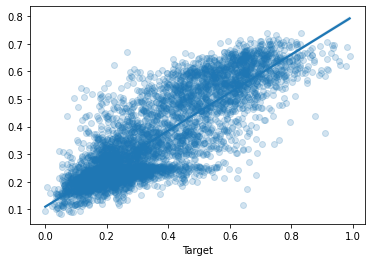

In [9]:
_ = sns.regplot(x=y_valid, y=model.predict(X_valid), scatter_kws={"alpha": 0.2})

In [10]:
mean_squared_error(y_valid, model.predict(X_valid), squared=False)

0.10399086162910336

In [11]:
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)
sample_submission.head()

,Target
ID,
ID_AAcismbB,0
ID_AAeBMsji,0
ID_AAjFMjzy,0
ID_AAmMOEEC,0
ID_ABguzDxp,0


In [12]:
sample_submission['Target'] = model.predict(test) 
sample_submission.head()

,Target
ID,
ID_AAcismbB,0.166323
ID_AAeBMsji,0.254748
ID_AAjFMjzy,0.647659
ID_AAmMOEEC,0.427584
ID_ABguzDxp,0.275242


In [13]:
sample_submission.to_csv('submission.csv')